In [1]:
import datacube_stats
from skimage import exposure
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import yaml
from datacube_stats import StatsApp
from datacube import Datacube

config_yaml = """
sources:
  - product: ls8_usgs_sr_scene
    measurements: [red, green, blue]
    masks:
      - product: ls8_usgs_sr_scene
        measurement: pixel_qa

        flags:
          cloud_shadow: no_cloud_shadow
          cloud: no_cloud
  - product: ls7_usgs_sr_scene
    measurements: [red, green, blue]
    masks:
      - product: ls7_usgs_sr_scene
        measurement: pixel_qa

        flags:
          cloud_shadow: no_cloud_shadow
          cloud: no_cloud
date_ranges:
    start_date: 2015-01-01
    end_date: 2016-01-01
storage:
    # this driver enables in-memory computation
    driver: xarray
    crs: EPSG:32616
    tile_size:
        x: 40000.0
        y: 40000.0
    resolution:
        x: 30
        y: -30
    chunking:
        x: 200
        y: 200
        time: 1
    dimension_order: [time, y, x]
computation:
    chunking:
        x: 800
        y: 800
input_region:
    x: [-105.4834, -105.3600]
    y: [21.5759, 21.7016]


output_products:
    - name: sr_geomedian
      statistic: geomedian
"""

# or manually creating a config dictionary works too
config = yaml.load(config_yaml)

print(yaml.dump(config, indent=4))

dc = Datacube()
app = StatsApp(config, dc.index)

print('generating tasks')
tasks = app.generate_tasks()

print('running tasks')
for task in tasks:
    # this method is only available for the xarray output driver
    output = app.execute_task(task)

print('processing complete')

computation:
    chunking: {x: 800, y: 800}
date_ranges: {end_date: 2016-01-01, start_date: 2015-01-01}
input_region:
    x: [-105.4834, -105.36]
    y: [21.5759, 21.7016]
output_products:
- {name: sr_geomedian, statistic: geomedian}
sources:
-   masks:
    -   flags: {cloud: no_cloud, cloud_shadow: no_cloud_shadow}
        measurement: pixel_qa
        product: ls8_usgs_sr_scene
    measurements: [red, green, blue]
    product: ls8_usgs_sr_scene
-   masks:
    -   flags: {cloud: no_cloud, cloud_shadow: no_cloud_shadow}
        measurement: pixel_qa
        product: ls7_usgs_sr_scene
    measurements: [red, green, blue]
    product: ls7_usgs_sr_scene
storage:
    chunking: {time: 1, x: 200, y: 200}
    crs: EPSG:32616
    dimension_order: [time, y, x]
    driver: xarray
    resolution: {x: 30, y: -30}
    tile_size: {x: 40000.0, y: 40000.0}

generating tasks
running tasks
processing complete


In [3]:
sr_geomedian = output.result['sr_geomedian']

In [4]:
def three_band_image(ds, bands=['red', 'green', 'blue'], time=0, figsize=(10, 10), title='Time',
                     projection='projected', contrast_enhance=False, percentile_stretch = [1, 99]):

    """
    This function takes three spectral bands and plots them as the RGB bands of an image.

    Last modified: May 2018
    Author: Mike Barnes
    Modified by: Claire Krause, Cate Kooymans, Robbi Bishop-Taylor


    :param ds:
        An xarray dataset containing the bands to be plotted. For correct axis scales, the xarray
        will ideally have spatial data (e.g. an `.extent` method)

    :param bands:
        Optional list of three bands to be plotted (defaults to `['red', 'green', 'blue']`)

    :param time:
        Optional index value of the time dimension of the xarray dataset to be plotted (defaults to 0)

    :param figsize:
        Optional tuple or list giving the dimensions of the output plot (defaults to `(10, 10)`)

    :param title:
        Optional string for the plot title. If left as the default 'Time', the title will be taken from
        the timestep of the plotted image if available

    :param projection:
        Determines if the image is in degrees or northings (options are 'projected' or 'geographic')

    :param contrast_enhance:
        Optionally transform data using a histogram stretch. If `contrast_enhance = True`,
        exposure.equalize_hist is used to transform the data. Else, the data are standardised relative
        to a default reflectance = 5000 (this can be customised using `reflect_stand`)

    :param percentile_stretch:
        Optionally allows you to have greater control over the contrast stretch by manually specifying 
        min and max percentiles used to stretch the image colours. Defaults to [1, 99], which produces 
        a vibrant image without extreme contrast sometimes produced using `contrast_enhance=True`. To
        plot the image as-is without any stretch, use `percentile_stretch=[0, 100].


    :return fig:
        A matplotlib figure object for customised plotting

    :return ax:
        A matplotlib axis object for customised plotting


    :example:
        >>> # Import external functions from dea-notebooks
        >>> sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
        >>> import DEAPlotting
        >>>
        >>> # Load Landsat time series
        >>> xarray_dataset = dc.load(product='ls8_nbart_albers', **query)
        >>>
        >>> # Plot as an RGB image
        >>> DEAPlotting.three_band_image(ds=xarray_dataset)

    """

    # Use different approaches to data prep depending on whether dataset has temporal dimension
    try:

        # Create new numpy array matching shape of xarray
        t, y, x = ds[bands[0]].shape
        rawimg = np.zeros((y, x, 3), dtype=np.float32)

        # Add xarray bands for a given time into three dimensional numpy array
        for i, colour in enumerate(bands):

            rawimg[:, :, i] = ds[colour][time].values
            
    except ValueError:

        # Create new numpy array matching shape of xarray
        y, x = ds[bands[0]].shape
        rawimg = np.zeros((y, x, 3), dtype=np.float32)

        # Add xarray bands into three dimensional numpy array
        for i, colour in enumerate(bands):

            rawimg[:, :, i] = ds[colour].values
            
    # Set nodata value to NaN
    rawimg[rawimg == -999] = np.nan

    # Optionally compute contrast based on histogram
    if contrast_enhance:

        # Stretch contrast using histogram
        # img_toshow = exposure.equalize_hist(rawimg, mask=np.isfinite(rawimg))
        p2, p98 = np.percentile(rawimg, (2, 98))
        img_toshow = exposure.rescale_intensity(rawimg, in_range=(p2, p98))
        
    else:

        # Stretch contrast using defined reflectance standardisation and clip to between 0 and 1
        # to prevent warnings; defaults to reflect_stand = 5000
        p2, p98 = np.percentile(rawimg, percentile_stretch)
        img_toshow = exposure.rescale_intensity(rawimg, in_range=(p2, p98))
        # img_toshow = (rawimg / reflect_stand).clip(0, 1)

    # Plot figure, setting x and y axes from extent of xarray dataset
    fig, ax = plt.subplots(figsize=figsize)

    try:

        # Plot with correct coords by setting extent if dataset has spatial data (e.g. an `.extent` method).
        # This also allows the resulting image to be overlaid with other spatial data (e.g. a polygon or point)
        left, bottom, right, top = ds.extent.boundingbox
        plt.imshow(img_toshow, extent=[left, right, bottom, top])

    except:

        # Plot without coords if dataset has no spatial data (e.g. an `.extent` method)
        print("xarray dataset has no spatial data; defaulting to plotting without coordinates. "
              "This can often be resolved by adding `keep_attrs = True` during an aggregation step")
        plt.imshow(img_toshow)

    # Set title by either time or defined title
    if title == 'Time':

        try:

            # Plot title using timestep
            ax.set_title(str(ds.time[time].values), fontweight='bold', fontsize=14)

        except:

            # No title
            ax.set_title('', fontweight='bold', fontsize=14)

    else:

        # Manually defined title
        ax.set_title(title, fontweight='bold', fontsize=14)

    # Set x and y axis titles depending on projection
    if projection == 'geographic':

        ax.set_xlabel('Longitude', fontweight='bold')
        ax.set_ylabel('Latitude', fontweight='bold')
        
    else:

        ax.set_xlabel('Eastings', fontweight='bold')
        ax.set_ylabel('Northings', fontweight='bold')
        
    return fig, ax

xarray dataset has no spatial data; defaulting to plotting without coordinates. This can often be resolved by adding `keep_attrs = True` during an aggregation step


(<matplotlib.figure.Figure at 0x7f53afb70cc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f53c73fe860>)

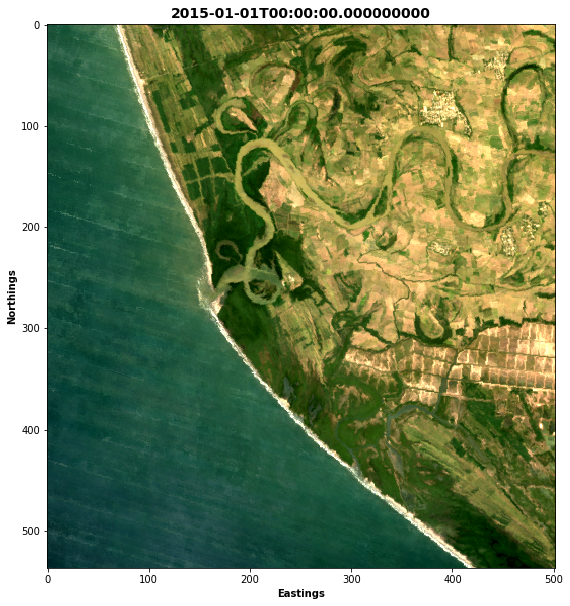

In [6]:
three_band_image(sr_geomedian)